## CMPE547: HW2 Generative Models
### M. Kutay Yabas

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Visualize the data (Step 1)

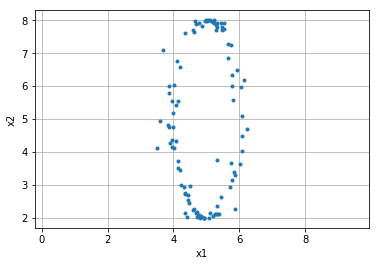

In [179]:
data = pd.read_csv('data.csv')
plt.plot(data.x1,data.x2,'.')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.grid()
plt.show()

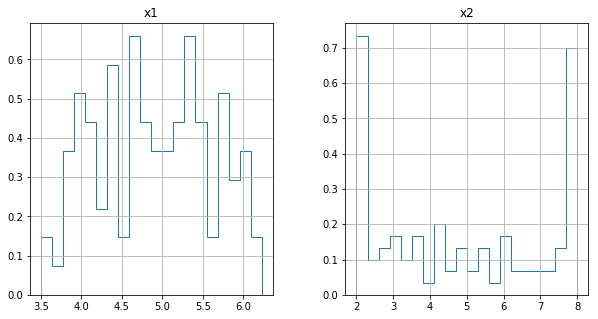

In [180]:
binnum=20
data.hist(figsize=(10,5),normed=True,bins=binnum,histtype="step")
plt.show()

x1 seems like a sinusodial distribution.

We will try to guess a model to generate x2 values from randomly generated new x1 values.

$f_{x_{2}}(x_{1})$ seems to be an elliptic model

I won't do it here but as the model is elliptic complex plane may also be used.

### Try to fit a model (Steps 2,3,4)

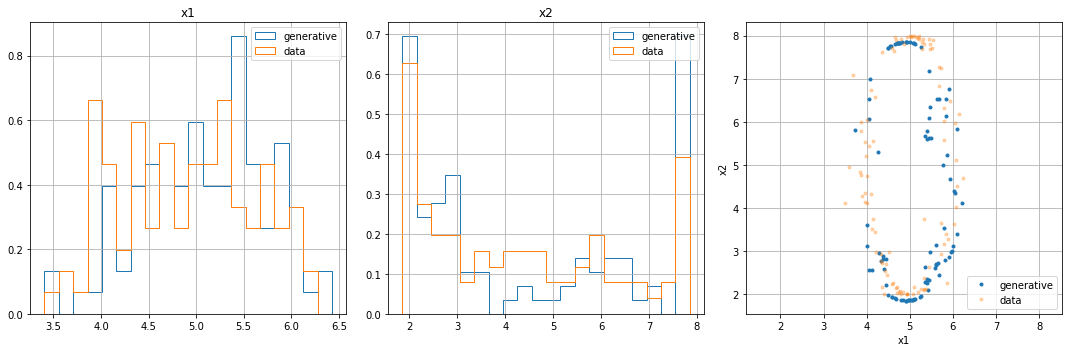

In [181]:
# First sample x1 from sin
randx = np.arcsin ( np.random.uniform (-1,1,data.x1.count()) )
randx = randx + data.x1.mean()

def model(data,randx):

    dist1 = ( data.x1.max() - data.x1.min() ) / 2
    dist2 = ( data.x2.max() - data.x2.min() ) / 2 # distances for the origin of the ellipse

    geny = np.sqrt (  ( 1 - ( ( ( randx-data.x1.mean()) / dist1 ) ** 2 ) ) * dist2**2  )
    geny = np.array( [y*random.choice([-1,1]) for y in geny]) + data.x2.mean()


    ### I have seen that model is not purely elliptic thus I have tried to manipulate the result.
    bot = data.x2.mean()-data.x2.min()
    top = data.x2.max() - bot
    left = data.x1.mean() - 0.6*data.x1.std() # 0.6 is experimental
    right = data.x1.mean() + 0.6*data.x1.std()

    for i,y in enumerate(geny):
        if randx[i] < left or randx[i] > right:
            if y > top:
                geny[i] = y -  0.4* np.random.uniform()*y # 0.4 is simply the end result of trial and error
            elif y < bot:
                geny[i] = y +  0.4* np.random.uniform()*y
    
    return geny
            

geny = model(data,randx)

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[2].plot(randx,geny,'.',label="generative")
ax[2].plot(data.x1,data.x2,'.',label="data",alpha=0.3)
ax[2].set_xlabel('x1')
ax[2].set_ylabel('x2')
ax[2].legend(loc=4)
ax[2].axis('equal')
ax[2].grid()

bins0 = ax[0].hist(randx,normed=True,bins=binnum,histtype="step",label="generative")
bins0_d = ax[0].hist(data.x1,normed=True,bins=bins0[1],histtype="step",label="data")
ax[0].grid()
ax[0].set_title('x1')
ax[0].legend(loc=0)

bins1 = ax[1].hist(geny[ ~np.isnan(geny) ],normed=True,histtype="step",label="generative",bins=binnum)
bins1_d = ax[1].hist(data.x2,normed=True,bins=bins1[1],histtype="step",label="data")
ax[1].grid()
ax[1].legend(loc=0)
ax[1].set_title('x2')
plt.tight_layout()
plt.show()

### Error assessment (Step 5)

For an unbiased estimator $\hat{\theta}$ root mean square error is calculated as

$RMSE(\theta) = \sqrt{ E[(\hat{\theta} - \theta)^2}$

Which is practically the average distance between true values $\theta$ and estimated values $\hat{\theta}$.

Firstly I run the RMSE function on purely generated data. $x_{1}$ is assumed to have a sin distribution and $x_{2}$ is generated from the random $x_{1}$.

Secondly I get the given $x_{1}$ values and generate $x_{2}$ valus with the generative function and use them to calculate RMSE on $x_{2}$.

These two different assessments results are similar. I think that second approach is better to fine tune the model. Broadly put, to construct ML models we will be given some data and try to find the best fit function. Thus if we assume x1 as the given, then $x_{2}$ is the result of our generative model. Then we fine tune the function so we can use it with newly generated $x_{1}$.

In [182]:
## Error
print( "x1 and x2 generated, RMSE on x2:", np.sqrt(np.mean((bins1[0]-bins1_d[0])**2)))

x1 and x2 generated, RMSE on x2: 0.102078450417


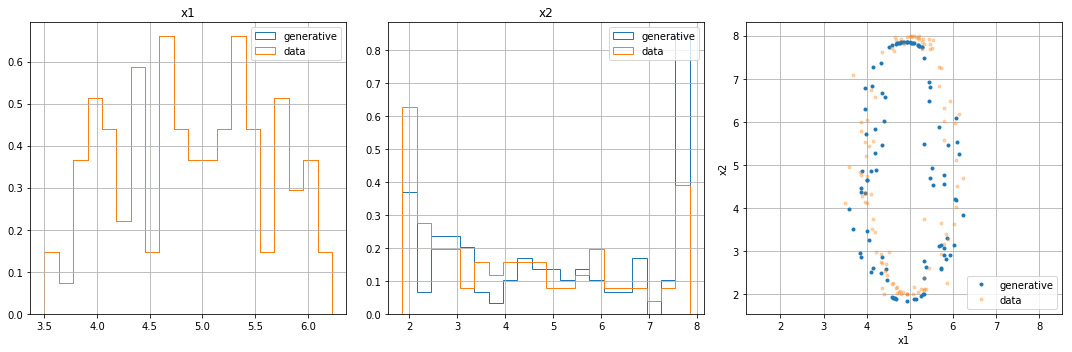

In [183]:
geny_x1 = model(data,data.x1)

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[2].plot(data.x1,geny_x1,'.',label="generative")
ax[2].plot(data.x1,data.x2,'.',label="data",alpha=0.3)
ax[2].set_xlabel('x1')
ax[2].set_ylabel('x2')
ax[2].legend(loc=4)
ax[2].axis('equal')
ax[2].grid()

bins0 = ax[0].hist(data.x1,normed=True,bins=binnum,histtype="step",label="generative")
bins0_d = ax[0].hist(data.x1,normed=True,bins=bins0[1],histtype="step",label="data")
ax[0].grid()
ax[0].set_title('x1')
ax[0].legend(loc=0)

bins1 = ax[1].hist(geny_x1[ ~np.isnan(geny_x1) ],normed=True,histtype="step",label="generative",bins=binnum)
bins1_d = ax[1].hist(data.x2,normed=True,bins=bins1[1],histtype="step",label="data")
ax[1].grid()
ax[1].legend(loc=0)
ax[1].set_title('x2')
plt.tight_layout()
plt.show()

In [184]:
print( "x1 given x2 generated, RMSE on x2:", np.sqrt(np.mean((bins1[0]-bins1_d[0])**2))/data.x2.mean())

x1 given x2 generated, RMSE on x2: 0.028110698796


### Further Error Analysis (Simple Monte Carlo)

Generative model is random in its nature and a single result is not enough to make an inference over the error. Thus we can make a simple monte carlo application and have an error distribution.

In [185]:
def generate_x1():
    randx = np.arcsin ( np.random.uniform (-1,1,data.x1.count()) )
    randx = randx + data.x1.mean()
    return randx

def calc_rmse(x2_generated, x2_true_value):
    hist_generated = np.histogram(x2_generated[ ~np.isnan(x2_generated) ],20,normed=True)
    hist_true_val = np.histogram(x2_true_value,bins=hist_generated[1],normed=True)
    rmse = np.sqrt(np.mean((hist_generated[0]-hist_true_val[0])**2)) 
    return rmse

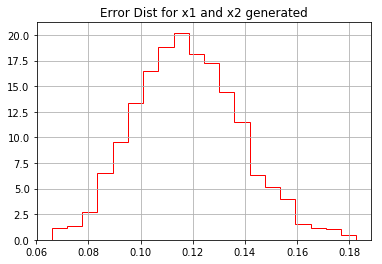

In [194]:
rmse = []
loop = 1000
for i in range(loop):
    rmse.append( calc_rmse(model(data,generate_x1()),data.x2) ) 

plt.hist(rmse,bins=binnum,normed=True,histtype="step",color="red")
plt.grid()
plt.title("Error Dist for x1 and x2 generated")

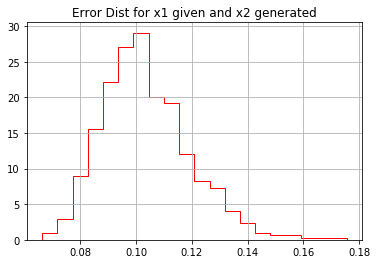

In [195]:
rmse = []
loop = 1000
for i in range(loop):
    rmse.append( calc_rmse(model(data,data.x1),data.x2) ) 

plt.hist(rmse,bins=binnum,normed=True,histtype="step",color="red")
plt.grid()
plt.title("Error Dist for x1 given and x2 generated")